Maximum height occured at y: 15372.219888375734 m, at time 104.0 seconds
Maximum velocity: 416.4691707183824 m/s, at time 69.0 seconds
Minimum velocity: -421.6205627907289 m/s, at time 165.5 seconds
Terminal velocity for our falling rocket happens at -509.53743299224647 m/s but our rocket only goes to -421.6205627907289 m/s


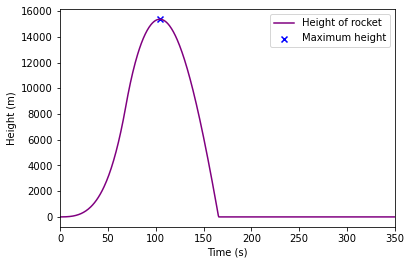

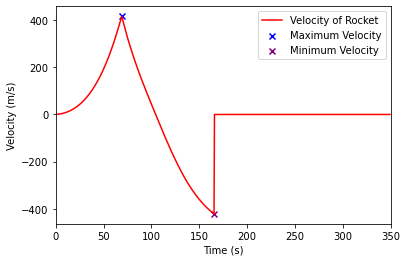

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sympy import symbols, lambdify, N
from numpy import pi, sqrt

# CONSTANTS =======================================================
g           = 9.81           # m/s^2
air_density = 1.22           # kg/m^3

m_rocket    = 4315           # kg
m_fuel_0    = 8931           # kg
m_total_0   = 13246          # kg

C           = 0.125          # unitless
D_rocket    = 1.65           # m
R_rocket    = D_rocket/2     # m
A_rocket    = pi*R_rocket**2 # m^2

v_edj       = 2050           # m/s
v_0         = 0              # m/s
y_0         = 0              # m
drag_0      = 0              # N

# Euler stuff
t_0       = 0.0                            #s
t_max     = 350                            #s
dt        = 0.5                            #s
numPoints = int(t_max/dt)
time   = np.arange(start = t_0,       #s
                   stop  = t_max, 
                   step  = dt) 

fuel_consumption_rate = 129.4 #kg/s

# symbols

v, m = symbols('v m', real=True) #velocity, mass

#Equations of force
F_g = m*g # grav
F_d = (1/2)*air_density*(v**2)*C*A_rocket # drag
F_t = v_edj*m # thrust

#FUNCTIONS ==========================================================
#Need functions to run against
F_g_func = lambdify(m, F_g)
F_d_func = lambdify(v, F_d)
F_t_func = lambdify(m, F_t)

# RESULTS ==========================================================

df = pd.DataFrame({'time' : time})
df['delta_time']   = dt
df['mass_rocket']  = m_rocket
df['mass_fuel']    = m_fuel_0 - df['time']*fuel_consumption_rate #has neg vals, need to clean

df['mass_fuel'].clip(lower=0, inplace=True) # cleaned

df['mass_total']   = df['mass_rocket'] + df['mass_fuel']
df['delta_mass']   = df['mass_total'].shift()-df['mass_total'] #shift grabs previous value

df.at[0, 'delta_mass'] = fuel_consumption_rate*dt #otherwise it's not consuming fuel for the first 0.5 seconds 
#which is nonsense

df['force_grav']   = -F_g_func(df['mass_total'])
df['force_thrust'] = F_t_func(df['delta_mass'])

#no way around this loop to my knowledge. Gotta get better with the Pandas
#initial values
v = v_0
y = y_0
force_drag = drag_0
#lists to add back into dataframe
velocity_list   = []
drag_force_list = []
height_list     = []
for index, t in df['time'].iteritems(): #iterate over time
    #getting info from dataframe
    force_grav   = df.iloc[index].loc['force_grav']
    force_thrust = df.iloc[index].loc['force_thrust']
    total_mass   = df.iloc[index].loc['mass_total']
    force_drag   = F_d_func(v)
    if(v>0): #opposes motion, in _both_ directions
        force_drag *= -1 
    dv = ((force_grav + force_thrust + force_drag)/total_mass)*dt
    v += dv # I tried interchanging these two, it doesn't change any result
    y += v*dt
    if(y < 0):
        y = 0 #No burrowing into the ground
    if(y == 0 and v<0):
        v = 0 #No accelerating into the Earth
    velocity_list.append(v)
    drag_force_list.append(force_drag)
    height_list.append(y)

#Back Into that wonderful dataframe
df['force_drag'] = drag_force_list
df['velocity'] = velocity_list
df['height']   = height_list
df['force_total'] = df['force_grav'] + df['force_thrust'] + df['force_drag']

df = df.astype(float) #breaks otherwise

# MAX Height ==========================================================
max_height_index = df.idxmax()['height'] #Getting index and max
max_height = df.iloc[max_height_index].loc['height']
max_height_time = df.iloc[max_height_index].loc['time']
print("Maximum height occured at y:", max_height, "m, at time", max_height_time, "seconds")

#Velocity, Min, Max, Terminal =========================================
vter = sqrt(m_rocket*g*2/(air_density*C*A_rocket)) #Calculating terminal velocity

min_vel_index = df.idxmin()['velocity'] #Getting index and max
min_velocity = df['velocity'].min()
min_vel_time = df.iloc[min_vel_index].loc['time']

max_vel_index = df.idxmax()['velocity']#Getting index and max
max_velocity = df['velocity'].max()
max_vel_time = df.iloc[max_vel_index].loc['time']

print("Maximum velocity:", max_velocity, "m/s, at time", max_vel_time, "seconds")
print("Minimum velocity:", min_velocity, "m/s, at time", min_vel_time, "seconds")
print("Terminal velocity for our falling rocket happens at", -vter, "m/s but our rocket only goes to", min_velocity, "m/s")

# PLOTTING ==========================================================
ax1 = df.plot(x='time', y='height', color='purple', label="Height of rocket")
ax1.scatter(max_height_time, max_height, marker='x', color='b', label='Maximum height')
ax1.legend()
ax1.set_xlabel('Time (s)')
ax1.set_ylabel('Height (m)')
ax1.set_xlim(0, 350) #cutting it down because this whole adventure lasts ~165s
plt.show() # You know, before the rocket slams into the ground at 421 m/s and everyone dies.

ax2 = df.plot(x='time', y='velocity', color='red', label='Velocity of Rocket') #red wuns go fasta
ax2.scatter(max_vel_time, max_velocity, marker='x', color='b', label='Maximum Velocity')
ax2.scatter(min_vel_time, min_velocity, marker='x', color='purple', label='Minimum Velocity')
ax2.set_xlabel('Time (s)')
ax2.set_ylabel('Velocity (m/s)')
ax2.legend()
ax2.set_xlim(0, 350)
plt.show()
# This is for me, you can ignore this
# Or not, I'm a comment not your boss
# ax3 = df.plot(x='time', y='force_total', color='blue', label='Total Force')
# df.plot(x='time', y='force_grav', color='red', label='Force of Gravity', ax=ax3)
# df.plot(x='time', y='force_drag', color='green', label='Force of Drag', ax=ax3)
# df.plot(x='time', y='force_thrust', color='orange', label='Force of Thrust', ax=ax3)
# ax3.set_xlabel('Time (s)')
# ax3.set_ylabel('Force (N)')
# ax3.legend()
# ax3.set_xlim(0, 170)
# plt.show()